In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import re
import os
import zlib
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import sys
import seaborn as sns
from sklearn.cluster import KMeans
import nltk
nltk.downloader.download('vader_lexicon')
from langdetect import detect

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV

In [3]:
#pip install xgboost

In [4]:
Spotify = pd.read_csv('SpotifyFeatures.csv')
lyrics = pd.read_csv('only_lyrics.csv')

## Merging lyrics and the songs

In [5]:
Spotify['track_name']=Spotify['track_name'].str.lower()
Spotify['track_name']=Spotify['track_name'].str.strip()
Spotify['artist_name']=Spotify['artist_name'].str.lower()
Spotify['artist_name']=Spotify['artist_name'].str.strip()
lyrics['song']=lyrics['song'].str.lower()
lyrics['song']=lyrics['song'].str.strip()
lyrics['artist']=lyrics['artist'].str.lower()
lyrics['artist']=lyrics['artist'].str.strip()

In [6]:
song_lyrics = Spotify.merge(lyrics, left_on=['track_name', 'artist_name'], right_on=['song', 'artist'])  

In [7]:
song_lyrics =song_lyrics.sort_values(by=['popularity'],ascending=False)
song_lyrics = song_lyrics.reset_index()


In [8]:
song_lyrics=song_lyrics.drop(['index','artist', 'song', 'link'], axis=1)

In [9]:
#clean_lyrics(song_lyrics.iloc[675,-1])

## Pre-processing lyrics

In [10]:
def clean_lyrics(lyrics):
    new_lyrics = re.sub(r'[\(\[].*?[\)\]]', ' ', lyrics)
    new_lyrics = new_lyrics.replace("\n", " ")
    #new_lyrics = new_lyrics.replace(""\"","")
    new_lyrics= new_lyrics.strip()
    new_lyrics= new_lyrics.replace("    ", " ")
    new_lyrics= new_lyrics.replace("   ", " ")
    new_lyrics= new_lyrics.replace("  ", " ")
    new_lyrics = os.linesep.join([s for s in new_lyrics.splitlines() if s])
    return(new_lyrics)

In [11]:
def get_compression_rate(lyrics):
    original = lyrics.encode('utf-8')
    compressed = zlib.compress(original)
    decompressed = zlib.decompress(compressed)
    
    compression_rate = (len(original)-len(compressed))/len(original)
    return compression_rate

In [12]:
#Apply clean_lyrics function to text column
song_lyrics['text'] = song_lyrics['text'].map(clean_lyrics)

#Append new column with compression rate
song_lyrics['compression_rate'] = song_lyrics['text'].map(get_compression_rate)

In [13]:
#Drop duplicates
song_lyrics = song_lyrics.sort_values(by='popularity', ascending=False)
song_lyrics = song_lyrics.drop_duplicates(subset='track_id', keep="first")

#Keep only english songs
song_lyrics['language'] = song_lyrics['text'].map(detect)
song_lyrics = song_lyrics[song_lyrics['language'] =="en"]

In [14]:
song_lyrics.head(1)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,text,compression_rate,language
0,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607,0.614,258987,0.379,0.000464,...,0.0986,-10.48,Major,0.0476,107.989,4/4,0.201,"Loving can hurt, loving can hurt sometimes. Bu...",0.643378,en


### Addition of sentment analysis (+,-,=) values

In [15]:
sia=SentimentIntensityAnalyzer()
sentiment = pd.DataFrame(columns=('id','senti_positive', 'senti_neutral', 'senti_negative'))
for i in range(len(song_lyrics['text'])):
    num_positive = 0
    num_negative = 0
    num_neutral = 0
    lyric= song_lyrics.iloc[i,-3]
    for j in lyric.split():
        comp = sia.polarity_scores(j)
        comp = comp['compound']
        #print(test)
        if comp >= 0.5:
            num_positive += 1
            #print('positive:',i)
        elif comp > -0.5 and comp < 0.5:
            num_neutral += 1
        else:
            num_negative += 1
        #print('negative:',i)
    sentiment.loc[i] = (song_lyrics.iloc[i,3],num_positive,num_neutral,num_negative)
#num_total = num_negative + num_neutral + num_positive
#print('Total score:',num_total)
#print('Negative score:',num_negative)
#print('Neutral score:',num_neutral)
#print('Positive score:',num_positive)
sentiment.head()

,id,senti_positive,senti_neutral,senti_negative
0,1HNkqx9Ahdgi1Ixy2xkKkL,6,310,5
1,2374M0fQpWi3dLnB54qaLX,0,268,0
2,1EzrEOXmMH3G43AXT1y7pA,13,295,0
3,34gCuhDGsG4bRPIf9bb02f,16,310,0
4,5Nm9ERjJZ5oyfXZTECKmRt,10,152,1


In [16]:
sentiment.shape

(5260, 4)

In [17]:
#sentiment['senti_total']=sentiment['senti_positive']+sentiment['senti_neutral']+sentiment['senti_negative']
sentiment['senti_%+']=(sentiment['senti_positive']/(sentiment['senti_positive']+sentiment['senti_neutral']+sentiment['senti_negative']))*100
sentiment['senti_%-']=(sentiment['senti_negative']/(sentiment['senti_positive']+sentiment['senti_neutral']+sentiment['senti_negative']))*100
sentiment['senti_%=']=(sentiment['senti_neutral']/(sentiment['senti_positive']+sentiment['senti_neutral']+sentiment['senti_negative']))*100
sentiment.head()

,id,senti_positive,senti_neutral,senti_negative,senti_%+,senti_%-,senti_%=
0,1HNkqx9Ahdgi1Ixy2xkKkL,6,310,5,1.86916,1.55763,96.5732
1,2374M0fQpWi3dLnB54qaLX,0,268,0,0,0,100
2,1EzrEOXmMH3G43AXT1y7pA,13,295,0,4.22078,0,95.7792
3,34gCuhDGsG4bRPIf9bb02f,16,310,0,4.90798,0,95.092
4,5Nm9ERjJZ5oyfXZTECKmRt,10,152,1,6.13497,0.613497,93.2515


In [18]:
sentiment.head()

,id,senti_positive,senti_neutral,senti_negative,senti_%+,senti_%-,senti_%=
0,1HNkqx9Ahdgi1Ixy2xkKkL,6,310,5,1.86916,1.55763,96.5732
1,2374M0fQpWi3dLnB54qaLX,0,268,0,0,0,100
2,1EzrEOXmMH3G43AXT1y7pA,13,295,0,4.22078,0,95.7792
3,34gCuhDGsG4bRPIf9bb02f,16,310,0,4.90798,0,95.092
4,5Nm9ERjJZ5oyfXZTECKmRt,10,152,1,6.13497,0.613497,93.2515


In [19]:
sentiment['senti_total']=sentiment['senti_positive']-sentiment['senti_negative']

In [20]:
sentiment=sentiment.drop(['senti_positive','senti_neutral', 'senti_negative'], axis=1)

In [21]:
song_lyrics = song_lyrics.merge(sentiment, left_on=['track_id'], right_on=['id'])
song_lyrics.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,time_signature,valence,text,compression_rate,language,id,senti_%+,senti_%-,senti_%=,senti_total
0,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607,0.614,258987,0.379,0.000464,...,4/4,0.201,"Loving can hurt, loving can hurt sometimes. Bu...",0.643378,en,1HNkqx9Ahdgi1Ixy2xkKkL,1.86916,1.55763,96.5732,1
1,Rock,toto,africa,2374M0fQpWi3dLnB54qaLX,85,0.257,0.671,295893,0.373,0.000080,...,4/4,0.732,I hear the drums echoing tonight But she hears...,0.637233,en,2374M0fQpWi3dLnB54qaLX,0,0,100,0
2,Pop,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595,0.686,242187,0.457,0.000000,...,4/4,0.718,Well you done done me and you bet I felt it I ...,0.572757,en,1EzrEOXmMH3G43AXT1y7pA,4.22078,0,95.7792,13
3,Pop,ed sheeran,thinking out loud,34gCuhDGsG4bRPIf9bb02f,85,0.474,0.781,281560,0.445,0.000000,...,4/4,0.591,When your legs don't work like they used to be...,0.623063,en,34gCuhDGsG4bRPIf9bb02f,4.90798,0,95.092,16
4,Pop,sam smith,stay with me,5Nm9ERjJZ5oyfXZTECKmRt,85,0.588,0.418,172724,0.420,0.000064,...,4/4,0.184,"Guess it's true, I'm not good at a one-night s...",0.640961,en,5Nm9ERjJZ5oyfXZTECKmRt,6.13497,0.613497,93.2515,9


In [22]:
song_lyrics=song_lyrics.drop(['id'], axis=1)

In [23]:
song_lyrics.shape

(5260, 25)

In [24]:
song_lyrics.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,tempo,time_signature,valence,text,compression_rate,language,senti_%+,senti_%-,senti_%=,senti_total
0,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607,0.614,258987,0.379,0.000464,...,107.989,4/4,0.201,"Loving can hurt, loving can hurt sometimes. Bu...",0.643378,en,1.86916,1.55763,96.5732,1
1,Rock,toto,africa,2374M0fQpWi3dLnB54qaLX,85,0.257,0.671,295893,0.373,0.000080,...,92.717,4/4,0.732,I hear the drums echoing tonight But she hears...,0.637233,en,0,0,100,0
2,Pop,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595,0.686,242187,0.457,0.000000,...,150.953,4/4,0.718,Well you done done me and you bet I felt it I ...,0.572757,en,4.22078,0,95.7792,13
3,Pop,ed sheeran,thinking out loud,34gCuhDGsG4bRPIf9bb02f,85,0.474,0.781,281560,0.445,0.000000,...,78.998,4/4,0.591,When your legs don't work like they used to be...,0.623063,en,4.90798,0,95.092,16
4,Pop,sam smith,stay with me,5Nm9ERjJZ5oyfXZTECKmRt,85,0.588,0.418,172724,0.420,0.000064,...,84.094,4/4,0.184,"Guess it's true, I'm not good at a one-night s...",0.640961,en,6.13497,0.613497,93.2515,9


In [25]:
song=song_lyrics['track_name']
song=song.str.strip()
song=song.str.split()
l=[]
for i in song:
    #print(len(i))
    l.append(len(i))
song_lyrics['track_length']=l 

## Addition of classes

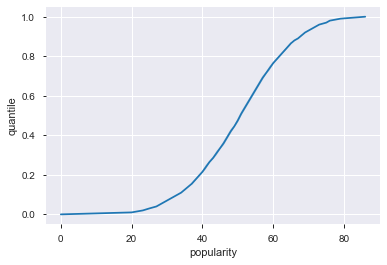

In [26]:
quantile=song_lyrics['popularity'].quantile(np.arange(0, 1.01, 0.01).tolist())
quantile=quantile.reset_index()
quantile.rename(columns={'index':'quantile'}, inplace=True)
sns.lineplot(quantile['popularity'],quantile['quantile'])

In [27]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(quantile)
quantile['cluster']=kmeans.predict(quantile)

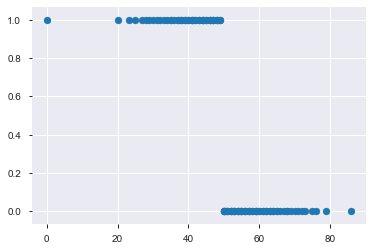

In [28]:
plt.scatter(quantile['popularity'],quantile['cluster'])

In [29]:
quantile

,quantile,popularity,cluster
0,0.00,0.00,1
1,0.01,20.00,1
2,0.02,23.18,1
3,0.03,25.00,1
4,0.04,27.00,1
5,0.05,28.00,1
6,0.06,29.00,1
7,0.07,30.00,1
8,0.08,31.00,1
9,0.09,32.00,1


In [30]:
one=quantile[quantile.cluster==1]
#two=quantile[quantile.cluster==2]
#three=quantile[quantile.cluster==3]
zero=quantile[quantile.cluster==0]
#four=quantile[quantile.cluster==4]
min_one=np.min(one['popularity'])
max_one=np.max(one['popularity'])
#min_two=np.min(two['popularity'])
#max_two=np.max(two['popularity'])
#min_three=np.min(three['popularity'])
#max_three=np.max(three['popularity'])
min_zero=np.min(zero['popularity'])
max_zero=np.max(zero['popularity'])
#min_four=np.min(four['popularity'])
#max_four=np.max(four['popularity'])
print(1,min_one,max_one)
#print(2,min_two,max_two)
#print(3,min_three,max_three)
#print(4,min_four,max_four)
print(0,min_zero,max_zero)

1 0.0 49.0
0 50.0 86.0


In [31]:
conditions = [
    (song_lyrics['popularity'] >= 50)&(song_lyrics['popularity'] <=100),
    (song_lyrics['popularity'] >= 42)&(song_lyrics['popularity'] <=49),
    (song_lyrics['popularity'] >= 38)&(song_lyrics['popularity'] <=41),
    (song_lyrics['popularity'] >= 20)&(song_lyrics['popularity'] <=37),
    (song_lyrics['popularity'] >= 19)&(song_lyrics['popularity'] <=0)]
choices = [1,0,0,0,0]
song_lyrics['label'] = np.select(conditions, choices)
song_lyrics.tail(1)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,valence,text,compression_rate,language,senti_%+,senti_%-,senti_%=,senti_total,track_length,label
5259,Country,kris kristofferson,why me,5xpd9uCrrCnh7ssgoAnAFK,0,0.861,0.626,177840,0.255,0.0,...,0.492,Why me Lord what have I ever done to deserve e...,0.504505,en,0.840336,0,99.1597,1,2,0


In [32]:
#song_lyrics

# Features Engineering

1. Analysing features distributions

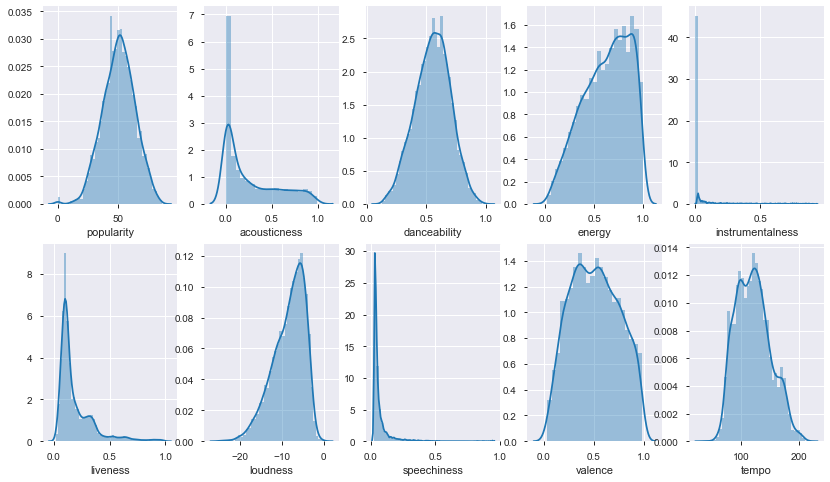

In [33]:
f, axes = plt.subplots(2, 5, figsize=(14, 8), sharex=False)
sns.distplot(song_lyrics['popularity'],ax=axes[0,0])
sns.distplot(song_lyrics['acousticness'],ax=axes[0,1])
sns.distplot(song_lyrics['danceability'],ax=axes[0,2])
sns.distplot(song_lyrics['energy'],ax=axes[0,3])
sns.distplot(song_lyrics['instrumentalness'],ax=axes[0, 4])
sns.distplot(song_lyrics['liveness'],ax=axes[1,0])
sns.distplot(song_lyrics['loudness'],ax=axes[1,1])
sns.distplot(song_lyrics['speechiness'],ax=axes[1,2])
sns.distplot(song_lyrics['valence'],ax=axes[1,3])
sns.distplot(song_lyrics['tempo'],ax=axes[1,4])

(array([ 13.,   1.,   6.,  19.,  28.,  93., 215., 251., 363., 457., 667.,
        644., 640., 687., 427., 301., 250., 122.,  54.,  22.]),
 array([ 0. ,  4.3,  8.6, 12.9, 17.2, 21.5, 25.8, 30.1, 34.4, 38.7, 43. ,
        47.3, 51.6, 55.9, 60.2, 64.5, 68.8, 73.1, 77.4, 81.7, 86. ]),
 <a list of 20 Patch objects>)

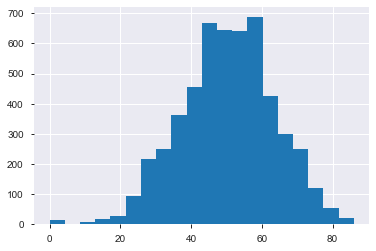

In [34]:
plt.hist(song_lyrics['popularity'], bins=20)

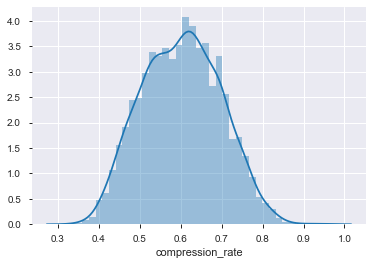

In [35]:
sns.distplot(song_lyrics['compression_rate'])

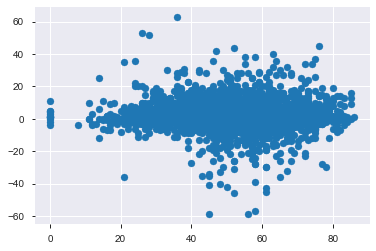

In [36]:
#plt.scatter(song_lyrics['popularity'],song_lyrics['senti_%+'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['senti_%='] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['senti_%-'] )
plt.scatter(song_lyrics['popularity'],song_lyrics['senti_total'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['speechiness'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['speechiness'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['valence'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['compression_rate'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['acousticness'] )

2. Encoding

In [37]:
# renaming data before classification

# track features
genre = song_lyrics['genre'].str.strip()
genre = song_lyrics['genre'].str.lower()
artist_name = song_lyrics['artist_name'].str.strip()
artist_name = song_lyrics['artist_name'].str.lower()
track_name = song_lyrics['track_name']
track_id = song_lyrics['track_id']

# spotify features
popularity = song_lyrics['popularity']
acousticness = song_lyrics['acousticness']
danceability = song_lyrics['danceability']
duration_ms = song_lyrics['duration_ms']
energy = song_lyrics ['energy']
instrumentalness = song_lyrics['instrumentalness']
key = song_lyrics['key']
liveness = song_lyrics['liveness']
loudness = song_lyrics['loudness']
mode = song_lyrics['mode']
speechiness = song_lyrics['speechiness']
tempo = song_lyrics['tempo']
time_signature = song_lyrics['time_signature']
valence = song_lyrics['valence']

# sentimental features
text = song_lyrics['text']
compression_rate = song_lyrics['compression_rate']
senti_positive = song_lyrics['senti_%+']
senti_neutral = song_lyrics['senti_%=']
senti_negative = song_lyrics['senti_%-']
senti_total = song_lyrics['senti_total']

In [38]:
# encoding discrete data

# track features
genre_encoded = pd.get_dummies(genre,prefix='genre', dummy_na=False)
artist_name_encoded = pd.get_dummies(artist_name,prefix='artist_name', dummy_na=False)

# spotify features 
key_encoded = pd.get_dummies(key,prefix='key', dummy_na=False)
mode_encoded = pd.get_dummies(mode,prefix='mode', dummy_na=False)
time_signature_encoded = pd.get_dummies(time_signature,prefix='time_signature', dummy_na=False)

#sentimal features 
#senti_positive_enoded = pd.get_dummies(senti_positive,prefix='senti_positive', dummy_na=False)
#senti_neutral_encoded = pd.get_dummies(senti_neutral,prefix='senti_neutral', dummy_na=False)
#senti_negative_encoded = pd.get_dummies(senti_negative,prefix='senti_negative', dummy_na=False)
#senti_total_encoded = pd.get_dummies(senti_total,prefix='senti_total', dummy_na=False)


In [39]:
#artist_name_encoded

In [40]:
final_num=pd.DataFrame({'track_length':song_lyrics['track_length'],'compression_rate':compression_rate,'acousticness':acousticness,'danceability':danceability,'duration_ms':duration_ms,'energy':energy,'instrumentalness':instrumentalness,'liveness':liveness,'loudness':loudness,'speechiness':speechiness,'tempo':tempo, 'valence':valence,'senti_%+':senti_positive, 'senti_%=':senti_neutral,'senti_%-':senti_negative, 'senti_total':senti_total })


In [41]:
final_num.head()

,track_length,compression_rate,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,senti_%+,senti_%=,senti_%-,senti_total
0,1,0.643378,0.607,0.614,258987,0.379,0.000464,0.0986,-10.480,0.0476,107.989,0.201,1.86916,96.5732,1.55763,1
1,1,0.637233,0.257,0.671,295893,0.373,0.000080,0.0481,-18.064,0.0323,92.717,0.732,0,100,0,0
2,2,0.572757,0.595,0.686,242187,0.457,0.000000,0.1050,-8.322,0.0468,150.953,0.718,4.22078,95.7792,0,13
3,3,0.623063,0.474,0.781,281560,0.445,0.000000,0.1840,-6.061,0.0295,78.998,0.591,4.90798,95.092,0,16
4,3,0.640961,0.588,0.418,172724,0.420,0.000064,0.1100,-6.444,0.0414,84.094,0.184,6.13497,93.2515,0.613497,9


In [42]:
final_encode=pd.concat([key_encoded,mode_encoded,time_signature_encoded,genre_encoded,artist_name_encoded],axis=1)

In [43]:
final=pd.concat([final_num,final_encode],axis=1)


In [44]:
label=song_lyrics['label']

In [45]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(final, label, test_size = 0.2, random_state = 1)

In [46]:
yTest.shape

(1052,)

In [47]:
RFC_Model = RandomForestClassifier()
RFC_Model.fit(xTrain, yTrain)
RFC_Predict = RFC_Model.predict(xTest)
RFC_Accuracy = accuracy_score(yTest, RFC_Predict)
print("Accuracy: " + str(RFC_Accuracy))

#RFC_AUC = roc_auc_score(yTest, RFC_Predict) 
#print("AUC: " + str(RFC_AUC))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.7880228136882129


In [48]:
KNN_Model = KNeighborsClassifier(n_neighbors=5)
KNN_Model.fit(xTrain, yTrain)
KNN_Predict = KNN_Model.predict(xTest)
KNN_Accuracy = accuracy_score(yTest, KNN_Predict)
print("Accuracy: " + str(KNN_Accuracy))

Accuracy: 0.5342205323193916


In [49]:
LR_Model = LogisticRegression()
LR_Model.fit(xTrain, yTrain)
LR_Predict = LR_Model.predict(xTest)
LR_Accuracy = accuracy_score(yTest, LR_Predict)
print("Accuracy: " + str(LR_Accuracy))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.564638783269962


In [50]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(xTrain, yTrain)
ada_pred = ada.predict(xTest)
ada_Accuracy = accuracy_score(yTest, ada_pred)
print("Accuracy: " + str(ada_Accuracy))

Accuracy: 0.8193916349809885


In [51]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
nb_pred = gnb.fit(xTrain, yTrain).predict(xTest)
nb_Accuracy = accuracy_score(yTest, nb_pred)
print("Accuracy: " + str(nb_Accuracy))

Accuracy: 0.6245247148288974
